## On the Practicality of Neural Nets for Time Series Regression

In [259]:
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

In [260]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.7.0


## Introduction

The article meant as a short guide and introduction to the design and implementation of a basic neural net for time series forecasting. **Time series forecasting can be considered as a sequential machine learning regression problem, in which the sequence data is converted into a series of feature values and the corresponding true or target value.** The target valueus required as regression is a supervised learning problem and the lagged time series values become the feature values.

We will follow a window or buffer approach in which we would have to consider an appropriate window size. Then we would move the window from left to right of the sequence or the series data. We will consider the value immediately to right of the window frame as target or the true value. So, each time-step we will shift or move the window so as to get a new row of features values and target value pairs. In this way we form the training data and training labels. In a similar way, we form the test and the validation dataset, which is typically required for a machine learning prediction model. Also, remember that for a predictive model, having a wider observation window and a narrow prediction window can give better results. Next, for the train-test-validation split ratio we will have to figure that out based on the size of the data. For this example I have used a split ratio of 0.8 and based on the seasonality of the data, we have taken a window size of 60. But these variables are all hyper-parameters, which requires some tuning to get the best possible results.


## Data

We will be using a dataset containing time indexed information on home sales in 18 American counties from the years of 2011-2021. A sample of the data is shown below:

In [266]:
## import & concat out three housing datasets
path = '/Users/andrewma/Desktop/Stat-Notes/data/'
df = pd.read_csv('data/texas_housing.csv')
df[['date','sales']].head(5)

,date,sales
0,2011-01-01,15
1,2011-02-01,20
2,2011-03-01,25
3,2011-04-01,25
4,2011-05-01,27


## Data Preprocessing 

In the interests of time and length of this article, we will be glossing over much of the EDA & data cleaning. This cleaning process can be found in the linked article [here](statisticsandrew.wordpress.com) on time series - both projects utilize the same housing dataset. With the assumption of data with proper types and no missing or deprecated values, let's move on to deriving the parameters of our neural net.

### Imputation of Missing Values

There are over ~2k rows with missing values.

In [262]:
""" ## clean dataset & impute missing values 
## impute missing values with probabilistic mean PCA
df.fillna(1, inplace=True)

## pop the two coluumns which contain ~2k missing values
total = df['total_listings'].values.reshape(1, -1)
month = df['month_inventory'].values.reshape(1, -1)

## implementation of SimpleImputer model 
imp_mean = SimpleImputer(missing_values = 1, strategy='mean')
imp_mean.fit(month); imp_mean.transform(month)
imp_mean.fit(total); imp_mean.transform(total)

month_filler = np.transpose(pd.DataFrame(imp_mean.transform(month)))
total_filler = np.transpose(pd.DataFrame(imp_mean.transform(total)))
df['total_listings'] = total_filler
df['month_inventory'] = month_filler """

## predefine features & labels
features = ['sales','dollar_vol','med_price','total_listings','month_inventory']
target = ['avg_price']

df = df.sort_values('date')

### Exploratory Visualizations

Firstly, there appears to be consistent upward trends for average price across all counties; after an additive decomposition alongside an ADFuller-Dickinson test on the residuals, we have shown in [this previous article](statisticsandrew.wordpress.com) that avg_price is indeed stationary and exhibits seasonality in 4-year cycles

<function matplotlib.pyplot.show(*args, **kw)>

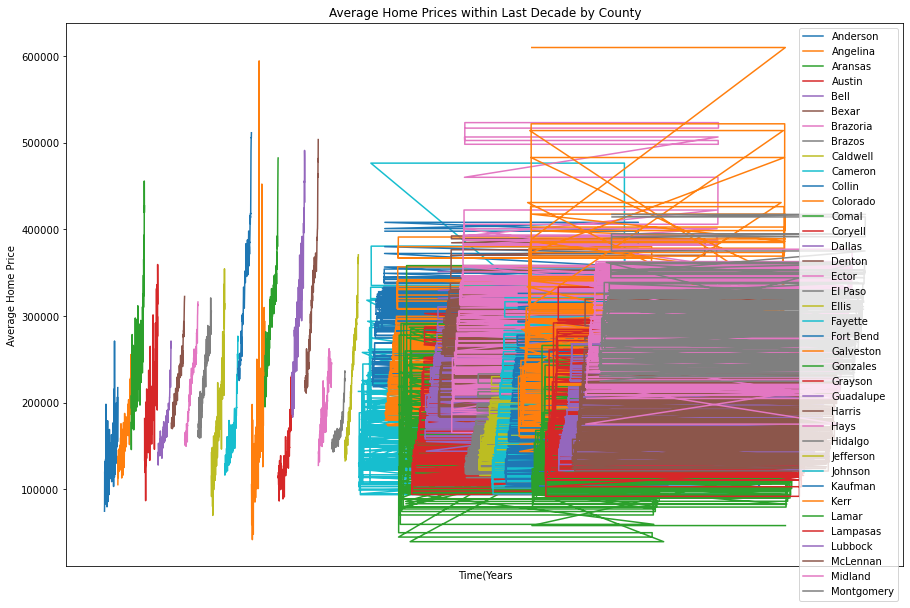

In [252]:
df['county'].unique

# setting the graph size globally
plt.rcParams['figure.figsize'] = (15, 10)

#gf = df.groupby('county')
df.groupby('county')['avg_price'].plot(legend=True)
plt.xticks([])

plt.title('Average Home Prices within Last Decade by County')
plt.xlabel('Time(Years')
plt.ylabel('Average Home Price')
plt.show

## Design & Development

After exploring the stationary and seasonality properties of our time series in question, we can begin to construct a basic neural net that is applicable to nonlinear regression. To answer this question, 

In [253]:
## normalize data as there is a large absolute difference between many of the predcitors which will result in 
## disproportionally large weights for some of the covariates 
minmax = MinMaxScaler()
df[features] = minmax.fit_transform(df[features])
df[target] = minmax.fit_transform(df[target])

## split into training & testing for Time series methods
## test = ~20% of data consisting most recent dates, train = all other data
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size = 0.2)

## Deep Neural Net

The ability of deep neural nets for . To impute a lag variable into our neural net, we will 

Now, as a best practice for Deep Neural Network training, it is always advisable to shuffle the training data and training in mini-batches instead of one at a time per epoch. For this reason, we will use a time series data generator routine, that creates the required pairs of feature values and target values and does the necessary random shuffling.

In [263]:
# Convert the data values to numpy for better and faster processing
time_index = np.array(df.index)
data = np.array(df['sales'])


# Certain Hyper-parameters to tune
SPLIT_RATIO = 0.8
WINDOW_SIZE = 20
BATCH_SIZE = 12
SHUFFLE_BUFFER = 100
learning_rate = 10

# Dividing into train-test split
split_index = int(SPLIT_RATIO * df.shape[0])

# Train-Test Split
train_data = data[:split_index]
train_time = time_index[:split_index]

test_data = data[split_index:]
test_time = time_index[split_index:]


def ts_data_generator(data, window_size, batch_size, shuffle_buffer):
  '''
  Utility function for time series data generation in batches
  '''
  ts_data = tf.data.Dataset.from_tensor_slices(data)
  ts_data = ts_data.window(window_size + 1, shift=1, drop_remainder=True)
  ts_data = ts_data.flat_map(lambda window: window.batch(window_size + 1))
  ts_data = ts_data.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  ts_data = ts_data.batch(batch_size).prefetch(1)
  return ts_data
train_dataset = ts_data_generator(train_data, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)
test_dataset = ts_data_generator(test_data, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)

To build and dpeloy a deep neural net, let's consturct a neural network with 4 layers: one for data normalization, two activation layers, and one prediction layer. 

After builidng this 

In [264]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape=[WINDOW_SIZE], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9))
model.fit(train_dataset, epochs=10,validation_data = test_dataset)

forecast=[]
for time in range(len(data) - WINDOW_SIZE):
  forecast.append(model.predict(data[time:time + WINDOW_SIZE][np.newaxis]))

forecast = forecast[split_index-WINDOW_SIZE:]
results = np.array(forecast)[:, 0, 0]

# Overall Error
error = tf.keras.metrics.mean_absolute_error(test_data, results).numpy()
print(error)

Epoch 1/10
485/485 [==============================] - 2s 3ms/step - loss: 786662.8750 - val_loss: 1172604.1250
Epoch 2/10
485/485 [==============================] - 1s 2ms/step - loss: 812192.7500 - val_loss: 1237986.1250
Epoch 3/10
485/485 [==============================] - 2s 3ms/step - loss: 813598.5000 - val_loss: 1237511.8750
Epoch 4/10
485/485 [==============================] - 2s 3ms/step - loss: 813237.4375 - val_loss: 1237038.5000
Epoch 5/10
485/485 [==============================] - 2s 3ms/step - loss: 812876.5000 - val_loss: 1236565.1250
Epoch 6/10
485/485 [==============================] - 2s 4ms/step - loss: 812516.2500 - val_loss: 1236092.1250
Epoch 7/10
485/485 [==============================] - 4s 8ms/step - loss: 812156.5000 - val_loss: 1235621.0000
Epoch 8/10
485/485 [==============================] - 3s 5ms/step - loss: 811798.3125 - val_loss: 1235151.2500
Epoch 9/10
485/485 [==============================] - 2s 5ms/step - loss: 811440.3125 - val_loss: 1234680.3750
E

Now we can test our predictions against the actual test data we had set aside: 

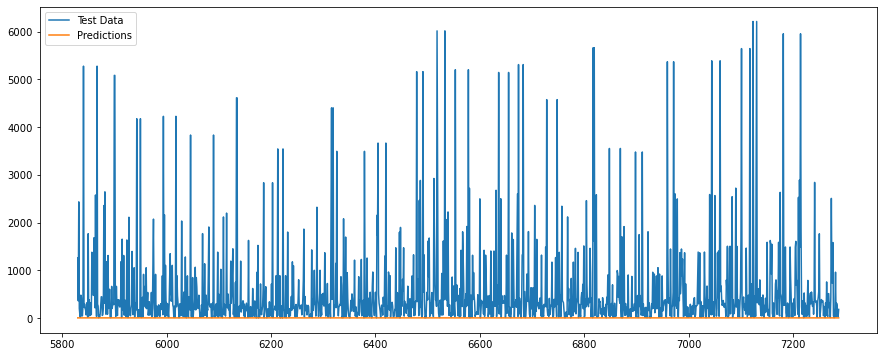

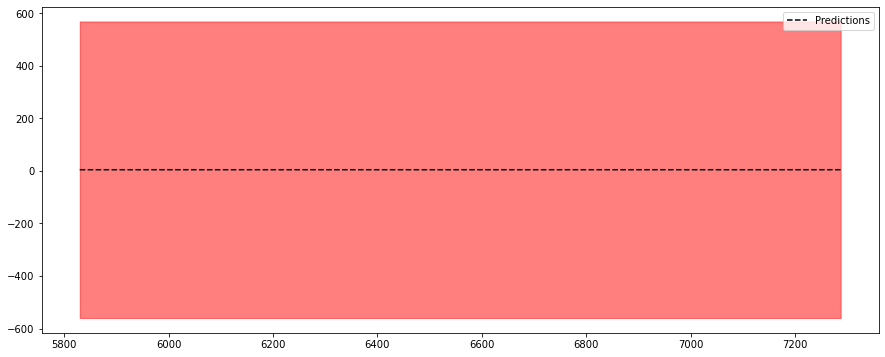

In [265]:
## plotting predictions against test
plt.figure(figsize=(15, 6))

plt.plot(list(range(split_index,len(data))), test_data, label = 'Test Data')
plt.plot(list(range(split_index,len(data))), results, label = 'Predictions')
plt.legend()
plt.show()

plt.figure(figsize=(15, 6))
# Plotting with Confidence Intervals
plt.plot(list(range(split_index,len(data))), results, 
        label = 'Predictions', color = 'k', linestyle = '--')
        
plt.fill_between(range(split_index,len(data)), results - error, 
                results + error, alpha = 0.5, color = 'red')
plt.legend()
plt.show()

In conclusion, Normalization layers in the model often helps to speed up and stabilize the learning process. If training with large batches isn't an issue and if the network doesn't have any recurrent connections, Batch Normalization could be used. With normalized data, we receive much better estimates of average home prices; our neural net seems to product safe weight estimates for this model. I suspect that there is a risk to increasing the number of epochs, window, or trianing data as that will surely lead to an increase in the variance of our estimates and the 

In [256]:
## Another Neural Network model with log-transformed data
minmax = MinMaxScaler()
df[features] = minmax.fit_transform(df[features])
df[target] = minmax.fit_transform(df[target])

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape=[WINDOW_SIZE], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer='adam')
model.fit(train_dataset, epochs=10, validation_data = test_dataset)

forecast=[]
for time in range(len(data) - WINDOW_SIZE):
  forecast.append(model.predict(data[time:time + WINDOW_SIZE][np.newaxis]))

forecast = forecast[split_index-WINDOW_SIZE:]
results = np.array(forecast)[:, 0, 0]

# Overall Error
error = tf.keras.metrics.mean_absolute_error(test_data, results).numpy()
print(error)

Epoch 1/10
485/485 [==============================] - 2s 3ms/step - loss: 678271.3750 - val_loss: 969694.0000
Epoch 2/10
485/485 [==============================] - 2s 3ms/step - loss: 658729.0000 - val_loss: 961192.0625
Epoch 3/10
485/485 [==============================] - 1s 3ms/step - loss: 653758.3750 - val_loss: 960167.6875
Epoch 4/10
485/485 [==============================] - 1s 3ms/step - loss: 651425.2500 - val_loss: 961816.1875
Epoch 5/10
485/485 [==============================] - 1s 3ms/step - loss: 648923.3125 - val_loss: 964820.9375
Epoch 6/10
485/485 [==============================] - 1s 3ms/step - loss: 646718.0000 - val_loss: 963580.3750
Epoch 7/10
485/485 [==============================] - 1s 3ms/step - loss: 645802.6875 - val_loss: 964763.0000
Epoch 8/10
485/485 [==============================] - 1s 3ms/step - loss: 644346.8125 - val_loss: 964810.9375
Epoch 9/10
485/485 [==============================] - 2s 3ms/step - loss: 642820.0625 - val_loss: 966525.0625
Epoch 10/1

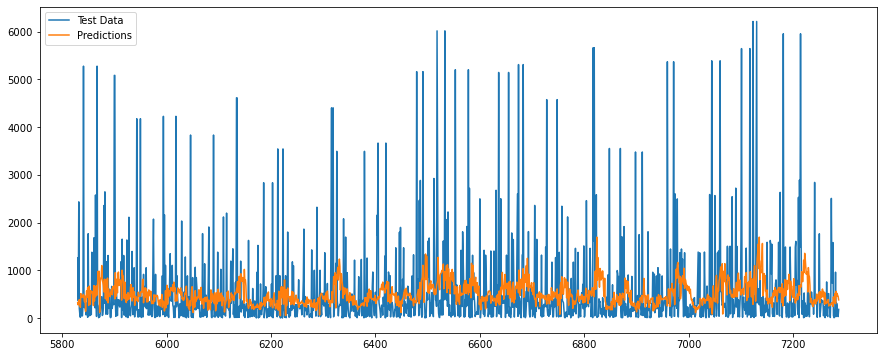

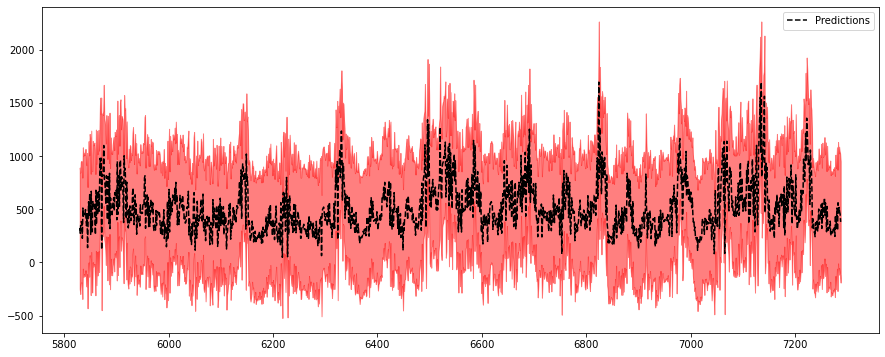

In [257]:
## plotting predictions against test
plt.figure(figsize=(15, 6))

plt.plot(list(range(split_index,len(data))), test_data, label = 'Test Data')
plt.plot(list(range(split_index,len(data))), results, label = 'Predictions')
plt.legend()
plt.show()

plt.figure(figsize=(15, 6))
# Plotting with Confidence Intervals
plt.plot(list(range(split_index,len(data))), results, 
        label = 'Predictions', color = 'k', linestyle = '--')
        
plt.fill_between(range(split_index,len(data)), results - error, 
                results + error, alpha = 0.5, color = 'red')
plt.legend()
plt.show()

## Discussion

As we can see from the plots of errirs above, our predications are actually pretty far off the true avergae prices across all counties. I believe that this is a classic example of the **Curse of dimensionality**. In essence, we are exploring this as a $n^4$ problem, where each interval of time is associated with . However, opportunies of parralelization are prevalent within the framework of neural nets.

**Since forecast can never be accurate, one should strive to keep forecasts within confidence intervals or error bands.**

For those who wish to dive deeper into the relationshio between Deep Neural Nets and Time Series Forecasting, 

## References

1. https://towardsdatascience.com/time-series-forecasting-using-tensorflow-and-deep-hybrid-learning-5088ad76dd55
2. https://aditya-bhattacharya.net/2020/07/11/time-series-tips-and-tricks/2/
3. https://scientistcafe.com/ids/projection-pursuit-regression.html
4. https://machinelearningmastery.com/loss-and-loss-functions-for-training-deep-learning-neural-networks/